**Extract Frames from Videos**

In [ ]:
import os
import cv2

def extract_frames_from_video(video_path, output_folder):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0

    while success:
        frame_path = os.path.join(output_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_path, image)
        success, image = vidcap.read()
        count += 1

    vidcap.release()

def main():
    main_folder = "cognitica/"
    actions = os.listdir(main_folder)

    for action in actions:
        action_folder = os.path.join(main_folder, action)
        if os.path.isdir(action_folder):
            output_folder = os.path.join(main_folder, f"{action}_frames")
            os.makedirs(output_folder, exist_ok=True)

            videos = [file for file in os.listdir(action_folder) if file.endswith('.avi')]

            for video in videos:
                video_path = os.path.join(action_folder, video)
                extract_frames_from_video(video_path, output_folder)

if __name__ == "__main__":
    main()


**Plot Random Images**

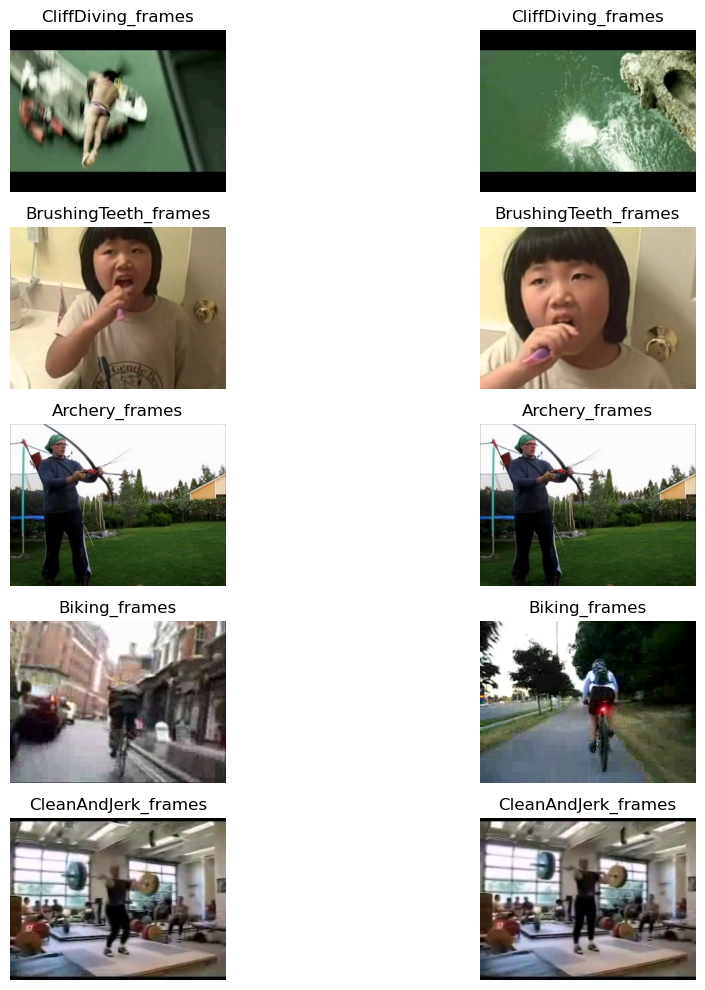

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_random_images_from_classes(base_path, num_classes=5, num_samples=2):
    all_classes = os.listdir(base_path)
    selected_classes = random.sample(all_classes, num_classes)

    plt.figure(figsize=(12, 10))

    for class_idx, class_name in enumerate(selected_classes):
        class_folder = os.path.join(base_path, class_name)
        if not os.path.exists(class_folder):
            continue

        image_files = os.listdir(class_folder)
        selected_images = random.sample(image_files, num_samples)

        for i, image_file in enumerate(selected_images):
            image_path = os.path.join(class_folder, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            plt.subplot(num_classes, num_samples, num_samples * class_idx + i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

base_path = 'cognitica/main/'
plot_random_images_from_classes(base_path)


In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data = {'Filepath': [], 'Filename': []}

for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)

    if os.path.isdir(class_path):
        frames_folder = os.path.join(class_path)
        for video_file in os.listdir(frames_folder):
            file_path = os.path.join(frames_folder, video_file)
            data['Filepath'].append(file_path)
            data['Filename'].append(class_folder)

df = pd.DataFrame(data)


**Train/Test Split and Data Generators**

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
dataset_root = 'cognitica/main/'

image_paths = []
labels = []
for class_name in os.listdir(dataset_root):
    class_path = os.path.join(dataset_root, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)
            labels.append(class_name)

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

batch_size = 32
target_size = (224, 224)

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepath': train_paths, 'Label': train_labels}),
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepath': test_paths, 'Label': test_labels}),
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11648 validated image filenames belonging to 40 classes.
Found 2912 validated image filenames belonging to 40 classes.


**Model Building (ResNet50 and LSTM)**

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Flatten, GlobalAveragePooling2D, Reshape,Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
pretrained_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224,3))
pretrained_model.trainable = False
k = 2
lstm_model = tf.keras.models.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Reshape((1, -1)),
    *[LSTM(64, return_sequences=True) for _ in range(k)],
    LSTM(64),
])

dropout_rate = 0.5
lstm_model.add(Dropout(dropout_rate))

activation_func = "relu"
lstm_model.add(Dense(40, activation="softmax"))

input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)
encoder_output = lstm_model(inputs)
combined_model = Model(inputs, encoder_output)

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             540928    
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                        

**Train Model**

In [ ]:
import time
optimizer = tf.keras.optimizers.Adam()
loss = "categorical_crossentropy"
metrics = ["accuracy"]
combined_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
start_time = time.time()

steps_per_epoch = len(train_generator)
val_steps_per_epoch = len(test_generator)
history = combined_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=val_steps_per_epoch
)

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total time taken for training: {total_training_time:.2f} seconds")

Epoch 1/10
364/364 [==============================] - 1140s 3s/step - loss: 0.8803 - accuracy: 0.7620 - val_loss: 0.6901 - val_accuracy: 0.8101
Epoch 2/10
364/364 [==============================] - 948s 3s/step - loss: 0.8104 - accuracy: 0.7837 - val_loss: 0.5513 - val_accuracy: 0.8747
Epoch 3/10
364/364 [==============================] - 977s 3s/step - loss: 0.7410 - accuracy: 0.8010 - val_loss: 0.5450 - val_accuracy: 0.8541
Epoch 4/10
364/364 [==============================] - 862s 2s/step - loss: 0.6835 - accuracy: 0.8201 - val_loss: 0.4900 - val_accuracy: 0.8695
Epoch 5/10
364/364 [==============================] - 992s 3s/step - loss: 0.6411 - accuracy: 0.8268 - val_loss: 0.4830 - val_accuracy: 0.8767
Epoch 6/10
364/364 [==============================] - 995s 3s/step - loss: 0.5963 - accuracy: 0.8437 - val_loss: 0.3801 - val_accuracy: 0.8956
Epoch 7/10
364/364 [==============================] - 964s 3s/step - loss: 0.5393 - accuracy: 0.8564 - val_loss: 0.3827 - val_accuracy: 0.904

In [ ]:
file_path = 'model.h5'
combined_model.save(file_path)

In [ ]:
print(combined_model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Plot Training History**

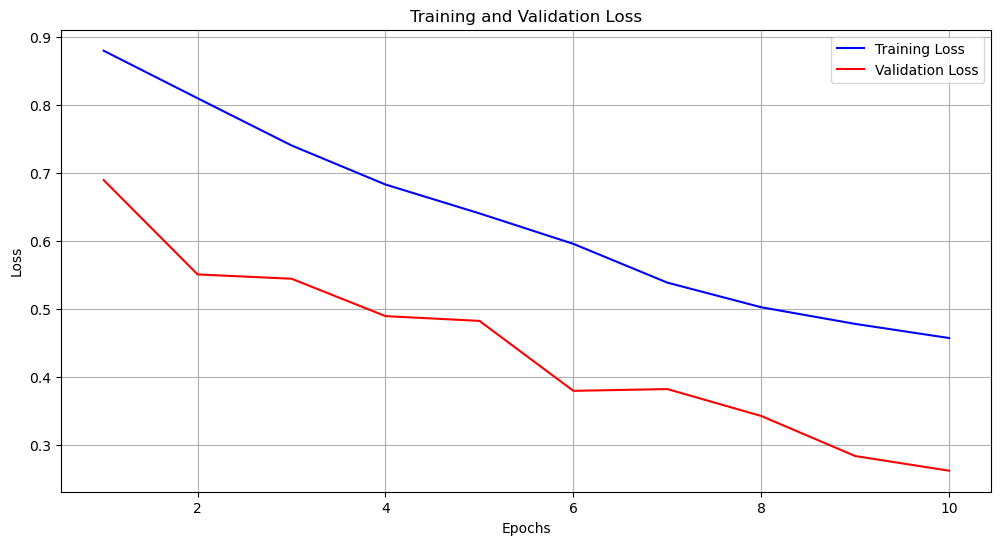

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


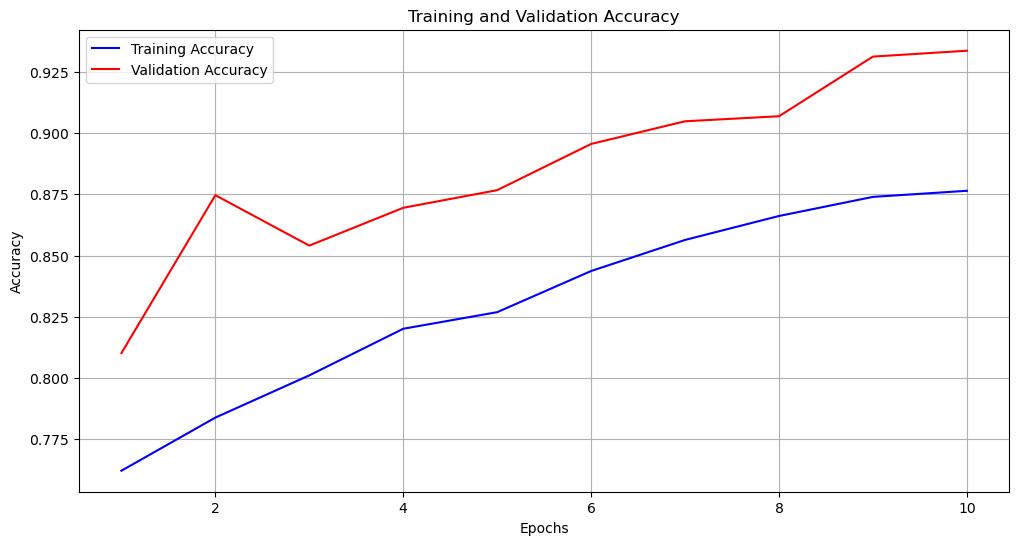

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class_names = ['ApplyEyeMakeup_frames','ApplyLipstick_frames','Archery_frames','BabyCrawling_frames','BalanceBeam_frames','BandMarching_frames','BaseballPitch_frames','Basketball_frames','BasketballDunk_frames','BenchPress_frames','Biking_frames','Billiards_frames',
'BlowDryHair_frames','BlowingCandles_frames','BodyWeightSquats_frames','Bowling_frames','BoxingPunchingBag_frames','BoxingSpeedBag_frames','BreastStroke_frames','BrushingTeeth_frames','CleanAndJerk_frames',
'CliffDiving_frames','CricketBowling_frames','CricketShot_frames','CuttingInKitchen_frames','Diving_frames','Drumming_frames','Fencing_frames','FieldHockeyPenalty_frames','FloorGymnastics_frames',
'FrisbeeCatch_frames','FrontCrawl_frames','GolfSwing_frames','Haircut_frames','Hammering_frames','HammerThrow_frames','HandstandPushups_frames','HandstandWalking_frames','HeadMassage_frames','HighJump_frames']

**Model Evaluation**

1/1 [==============================] - 3s 3s/step


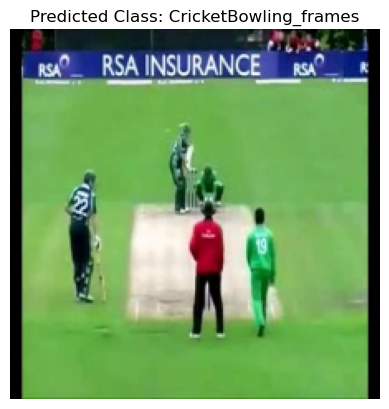

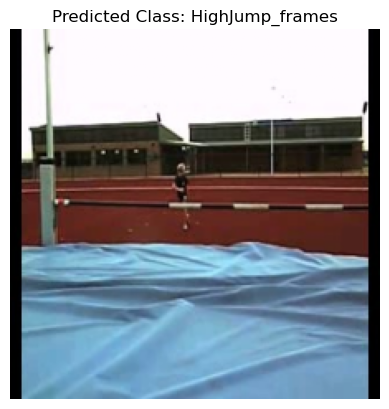

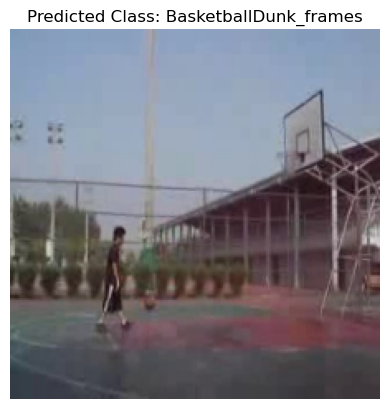

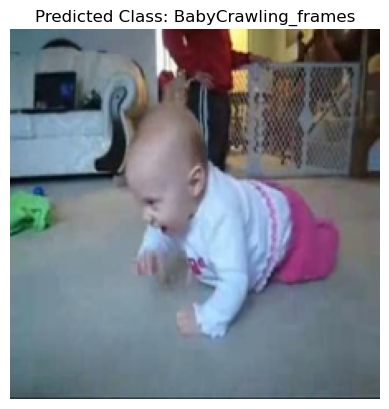

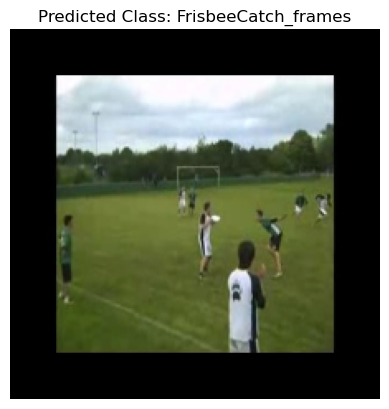

In [ ]:
def predict_expression(model, image_paths, target_size):
    test_images = [load_image(file_path, target_size) for file_path in image_paths]
    test_images = np.array(test_images)

    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    return test_images, predicted_labels

def load_image(file_path, target_size):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0

    return image

image_paths = [
    'cognitica/main/CricketBowling_frames/frame_0010.jpg',
    'cognitica/main/HighJump_frames/frame_0005.jpg',
    'cognitica/main/Basketball_frames/frame_0007.jpg',
    'cognitica/main/BabyCrawling_frames/frame_0010.jpg',
    'cognitica/main/FrisbeeCatch_frames/frame_0008.jpg'
]
target_size = (224, 224)
model = tf.keras.models.load_model('model.h5')
test_images, predicted_labels = predict_expression(model, image_paths, target_size)

for i in range(len(image_paths)):
    plt.imshow(test_images[i])
    plt.title(f'Predicted Class: {class_names[predicted_labels[i]]}')
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
train_batch_size = 16
test_batch_size = 16

num_train_samples = len(train_generator)
num_train_batches = num_train_samples // train_batch_size
num_test_samples = len(test_generator)
num_test_batches = num_test_samples // test_batch_size

train_images = []
train_labels = []
test_images = []
test_labels = []

for batch_index in range(num_train_batches):
    batch_images, batch_labels = next(train_generator)
    train_images.append(batch_images)
    train_labels.append(batch_labels)

for batch_index in range(num_test_batches):
    batch_images, batch_labels = next(test_generator)
    test_images.append(batch_images)
    test_labels.append(batch_labels)

train_images = np.vstack(train_images)
train_labels = np.vstack(train_labels)
test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels)

train_predictions = model.predict(train_images)
train_predicted_labels = np.argmax(train_predictions, axis=1)
test_predictions = model.predict(test_images)
test_predicted_labels = np.argmax(test_predictions, axis=1)

true_train_class_indices = np.argmax(train_labels, axis=1)
true_train_class_names = [str(class_names[label]) for label in true_train_class_indices]
train_predicted_class_names = [str(class_names[label]) for label in train_predicted_labels]

true_test_class_indices = np.argmax(test_labels, axis=1)
true_test_class_names = [str(class_names[label]) for label in true_test_class_indices]
test_predicted_class_names = [str(class_names[label]) for label in test_predicted_labels]

train_confusion_mat = confusion_matrix(true_train_class_names, train_predicted_class_names)
train_classification_rep = classification_report(true_train_class_names, train_predicted_class_names)

5/5 [==============================] - 9s 2s/step


**Classification Report**

In [ ]:
print("Train Set Classification Report:")
print(train_classification_rep)

Train Set Classification Report:
                           precision    recall  f1-score   support

    ApplyEyeMakeup_frames       1.00      0.94      0.97        16
     ApplyLipstick_frames       0.96      0.96      0.96        26
           Archery_frames       1.00      1.00      1.00        32
      BabyCrawling_frames       0.93      0.88      0.90        16
       BalanceBeam_frames       0.95      0.90      0.93        21
      BandMarching_frames       1.00      1.00      1.00        21
     BaseballPitch_frames       0.71      0.83      0.77         6
    BasketballDunk_frames       0.93      1.00      0.96        27
        Basketball_frames       1.00      1.00      1.00         9
        BenchPress_frames       0.94      1.00      0.97        15
            Biking_frames       0.97      1.00      0.98        30
         Billiards_frames       0.97      1.00      0.99        33
       BlowDryHair_frames       1.00      0.96      0.98        25
    BlowingCandles_frames   

In [ ]:
print("Test Set Classification Report:")
print(test_classification_rep)

Test Set Classification Report:
                           precision    recall  f1-score   support

    ApplyEyeMakeup_frames       1.00      0.80      0.89         5
     ApplyLipstick_frames       0.90      1.00      0.95         9
           Archery_frames       1.00      1.00      1.00         7
      BabyCrawling_frames       1.00      0.80      0.89         5
       BalanceBeam_frames       1.00      0.67      0.80         3
      BandMarching_frames       1.00      1.00      1.00         9
     BaseballPitch_frames       1.00      1.00      1.00         3
    BasketballDunk_frames       1.00      0.88      0.93         8
        Basketball_frames       0.67      1.00      0.80         2
        BenchPress_frames       1.00      1.00      1.00         2
            Biking_frames       1.00      1.00      1.00         6
         Billiards_frames       1.00      1.00      1.00        10
       BlowDryHair_frames       1.00      1.00      1.00         7
    BlowingCandles_frames    

**Confusion Matrix**

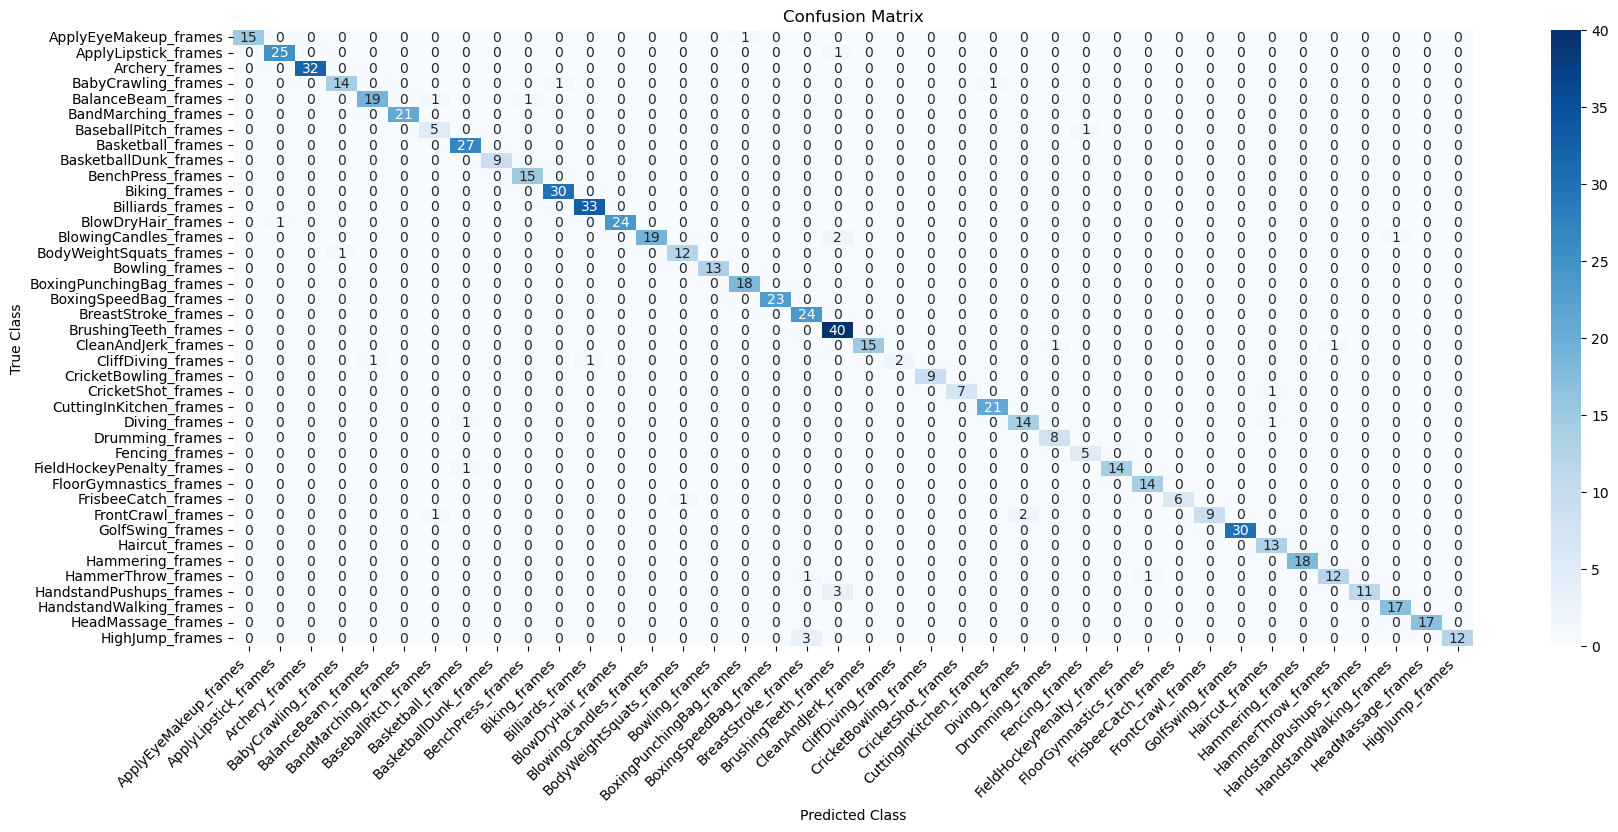

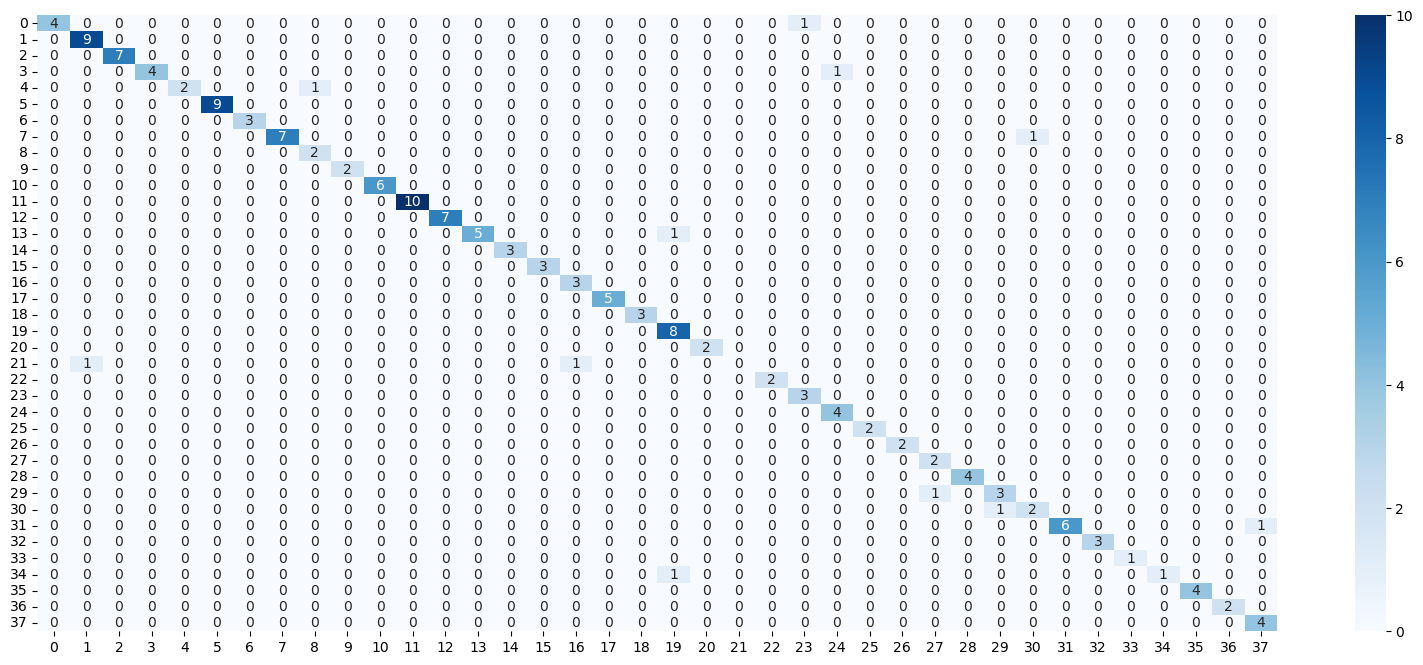

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat, class_names):
    plt.figure(figsize=(20, 8))
    ax = sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names, va='center')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()
try:
    plot_confusion_matrix(train_confusion_mat, class_names)

    plot_confusion_matrix(test_confusion_mat, class_names)
except ValueError:
    pass
